## Libraries

In [3]:
import numpy as np
import import_ipynb
import time
import os
import MEng_Final_Utils as utils

importing Jupyter notebook from MEng_Final_Utils.ipynb


Using TensorFlow backend.


In [4]:
from keras import applications
from keras.preprocessing import image
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras import Model
import pandas as pd
import itertools
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping

## Constants

In [5]:
np.random.seed(0)

In [6]:
base_path = "/export/home/grad/islab_archives/STUDENT_THESIS_dr/MILAN_SHARMA_MENG_dr/DATA_dr"

In [7]:
images_path = os.path.join(base_path,'Images_Balanced')
labels_path = os.path.join(base_path,'Labels_Balanced.xlsx')

In [8]:
labels_names = ['Window', 'Board','Table','External_Door','Stair Door','Office', 'Pillar', 'Display Screen',
                   'ATM','Chairs','Bins','Internal Door','Elevator']

In [10]:
num_labels = len(labels_names)
resize_factor = 0.1

## Read Images and Labels

In [11]:
images = utils.get_images(utils.get_files(images_path))
labels = utils.read_labels(labels_path,labels_names)[:len(images),:]
labels = labels.astype(int)

In [12]:
images_filenames = []
for i in range(0,len(images)):
    filename = str(i+1)+'.jpg'
    images_filenames.append(filename)
    
images_filenames = np.asarray(images_filenames)

## Train-Test Split and Image Data Generator

In [13]:
images_df  = pd.DataFrame(data=labels,columns=labels_names)
images_df.insert(0,'Filenames', images_filenames)

In [14]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(images_df, random_state=0, test_size=0.2)

In [15]:
train_datagen = ImageDataGenerator(
                rotation_range=0,
                width_shift_range=10,
                height_shift_range=10,
                horizontal_flip=True,
                fill_mode='nearest',
                rescale=1./255,
                data_format='channels_last',
                validation_split=0.10)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_aug = train_datagen.flow_from_dataframe(train_df,
                        directory=images_path,
                        x_col='Filenames',
                        y_col=labels_names,
                        target_size=(128,128),
                        color_mode='rgb',
                        class_mode='other',
                        batch_size=30,
                        shuffle=True,
                        seed=0,
                        drop_duplicates=True,
                        subset='training')

val_aug = train_datagen.flow_from_dataframe(train_df,
                        directory=images_path,
                        x_col='Filenames',
                        y_col=labels_names,
                        target_size=(128,128),
                        color_mode='rgb',
                        class_mode='other',
                        batch_size=30,
                        shuffle=True,
                        seed=0,
                        drop_duplicates=True,
                        subset='validation')


test_aug = test_datagen.flow_from_dataframe(test_df,
                        directory=images_path,
                        x_col='Filenames',
                        y_col=labels_names,
                        target_size=(128,128),
                        color_mode='rgb',
                        class_mode='other',
                        batch_size=1000,
                        shuffle=False,
                        seed=0)

Found 341 images.
Found 37 images.
Found 95 images.


In [18]:
val_augmented_data = []
for image,label in zip(val_aug,range(1)):
    val_augmented_data.append(image)

In [19]:
test_augmented_data = []
for image,label in zip(test_aug,range(1)):
    test_augmented_data.append(image)

In [20]:
validation_images, val_labels = utils.get_augmented_images_and_labels(val_augmented_data)
testing_images, test_labels = utils.get_augmented_images_and_labels(test_augmented_data)

In [21]:
validation_ims = (np.asarray(validation_images))
testing_ims = (np.asarray(testing_images))

In [22]:
w = testing_ims[0].shape[0]
h = testing_ims[0].shape[1]
d = testing_ims[0].shape[2]

## MobileNet Fine-Tuning

In [23]:
early_ae_hog = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [24]:
base_model_mn = applications.mobilenet.MobileNet(weights='imagenet', include_top=False,
                                                 pooling='avg', input_shape=((128,128,3)))

In [25]:
base_model_mn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [26]:
x = base_model_mn.output
x = Dropout(0.2)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_labels, activation='sigmoid')(x)
model_mn = Model(input=base_model_mn.input, output=output_layer)

# for layer in base_model_mn.layers:
#     layer.trainable = False

/export/home/users/msharm05/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [27]:
model_mn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [32]:
model_mn.compile(optimizer=optimizers.adam(lr=0.0001), loss='binary_crossentropy', metrics =['accuracy','binary_crossentropy'])
history_model_mn = model_mn.fit_generator(train_aug, steps_per_epoch=11,
                                epochs=60, validation_data=(validation_ims,val_labels),
                                verbose=1,
                                callbacks=[early_ae_hog])

Epoch 1/60
11/11 [==============================] - 99s 9s/step - loss: 1.0293 - acc: 0.4543 - binary_crossentropy: 1.0293 - val_loss: 0.8625 - val_acc: 0.4655 - val_binary_crossentropy: 0.8625
Epoch 2/60
11/11 [==============================] - 93s 8s/step - loss: 0.9081 - acc: 0.5000 - binary_crossentropy: 0.9081 - val_loss: 0.7643 - val_acc: 0.5312 - val_binary_crossentropy: 0.7643
Epoch 3/60
11/11 [==============================] - 92s 8s/step - loss: 0.8130 - acc: 0.5537 - binary_crossentropy: 0.8130 - val_loss: 0.6845 - val_acc: 0.6068 - val_binary_crossentropy: 0.6845
Epoch 4/60
11/11 [==============================] - 92s 8s/step - loss: 0.7316 - acc: 0.5934 - binary_crossentropy: 0.7316 - val_loss: 0.6195 - val_acc: 0.6550 - val_binary_crossentropy: 0.6195
Epoch 5/60
11/11 [==============================] - 93s 8s/step - loss: 0.6663 - acc: 0.6460 - binary_crossentropy: 0.6663 - val_loss: 0.5676 - val_acc: 0.7043 - val_binary_crossentropy: 0.5676
Epoch 6/60
11/11 [============

11/11 [==============================] - 92s 8s/step - loss: 0.1878 - acc: 0.9262 - binary_crossentropy: 0.1878 - val_loss: 0.2055 - val_acc: 0.9244 - val_binary_crossentropy: 0.2055
Epoch 44/60
11/11 [==============================] - 92s 8s/step - loss: 0.1848 - acc: 0.9314 - binary_crossentropy: 0.1848 - val_loss: 0.2029 - val_acc: 0.9233 - val_binary_crossentropy: 0.2029
Epoch 45/60
11/11 [==============================] - 93s 8s/step - loss: 0.1825 - acc: 0.9295 - binary_crossentropy: 0.1825 - val_loss: 0.2006 - val_acc: 0.9244 - val_binary_crossentropy: 0.2006
Epoch 46/60
11/11 [==============================] - 92s 8s/step - loss: 0.1781 - acc: 0.9292 - binary_crossentropy: 0.1781 - val_loss: 0.1987 - val_acc: 0.9233 - val_binary_crossentropy: 0.1987
Epoch 47/60
11/11 [==============================] - 92s 8s/step - loss: 0.1687 - acc: 0.9372 - binary_crossentropy: 0.1687 - val_loss: 0.1965 - val_acc: 0.9255 - val_binary_crossentropy: 0.1965
Epoch 48/60
11/11 [==================

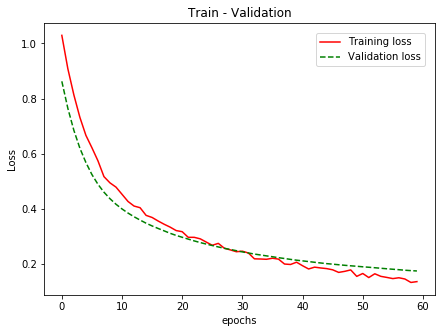

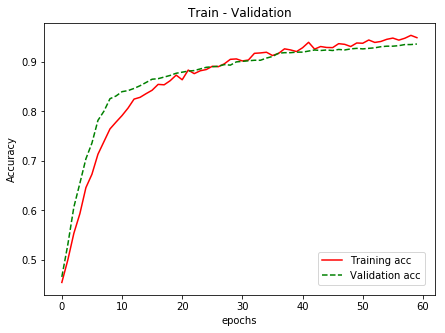

In [34]:
utils.model_performance_vis(history_model_mn,'Loss','loss')
utils.model_performance_vis1(history_model_mn,'Accuracy','acc')

MEng_Final_Utils.ipynb:25: RuntimeWarning: invalid value encountered in double_scalars
  "\n",
MEng_Final_Utils.ipynb:42: RuntimeWarning: Mean of empty slice
  "\n",
MEng_Final_Utils.ipynb:43: RuntimeWarning: Mean of empty slice
  "# Bag of Words using KMeans\n",


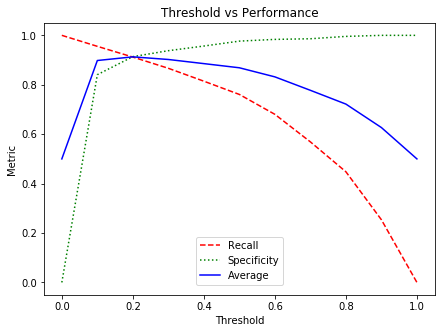

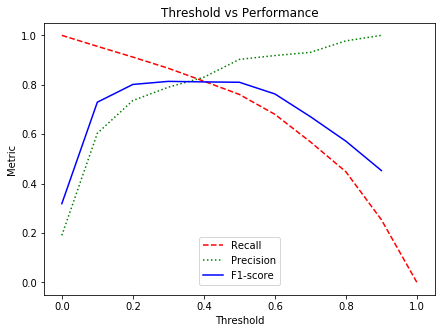

In [35]:
predicted_values_mn = utils.predict_and_threshold(model_mn,testing_ims,test_labels)

In [36]:
model_mn.evaluate(testing_ims,test_labels)

83/83 [==============================] - 4s 53ms/step


[0.17391994721200094, 0.9364731850394283, 0.17391994721200094]

In [104]:
predicted_labels = utils.threshold_labels(predicted_values_mn,0.22)
print('     TPR       TNR         Avg.')
print(utils.model_evaluation(test_labels,predicted_labels)[0])

     TPR       TNR         Avg.
[0.90644885 0.92179904 0.91412395 0.91894852 0.75356406 0.81072842]


In [38]:
t1 = time.perf_counter()
predicitions = model_mn.predict(testing_ims)
t2 = time.perf_counter()

In [28]:
runtime = (t2-t1)/len(testing_images)
print(runtime)

## AUC ROC and PR

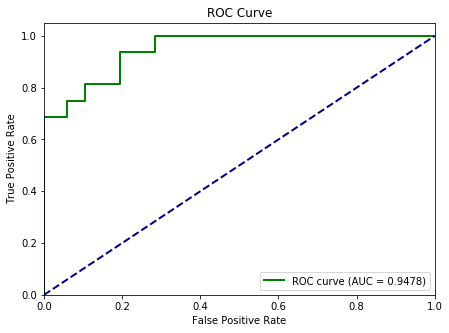

In [125]:
utils.get_roc_curve(predicted_values_mn, test_labels)

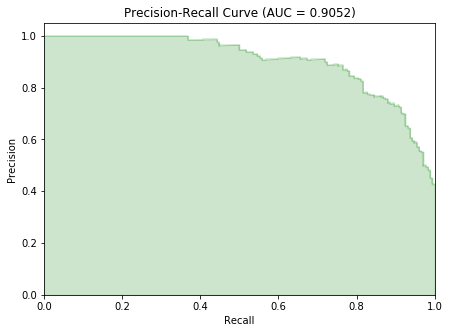

In [126]:
utils.get_precision_recall_curve(predicted_values_mn, test_labels)

In [73]:
model_mn.save('MobileNetV1_Trained.h5')